In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sohansakib75/pmrambrain")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pmrambrain


In [2]:
import os

for root, dirs, files in os.walk("/kaggle/input/pmrambrain"):
    for d in dirs:
        print(os.path.join(root, d))


/kaggle/input/pmrambrain/Raw
/kaggle/input/pmrambrain/Raw/512Glioma
/kaggle/input/pmrambrain/Raw/512Meningioma
/kaggle/input/pmrambrain/Raw/512Pituitary
/kaggle/input/pmrambrain/Raw/512Normal



Class: 512Glioma, Image: glioma (123).jpg


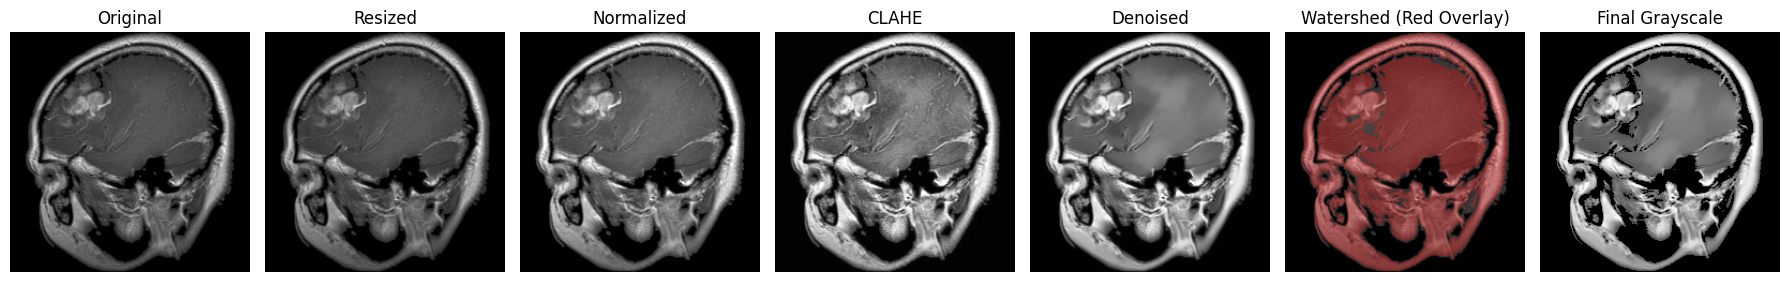


Class: 512Meningioma, Image: M_187.jpg


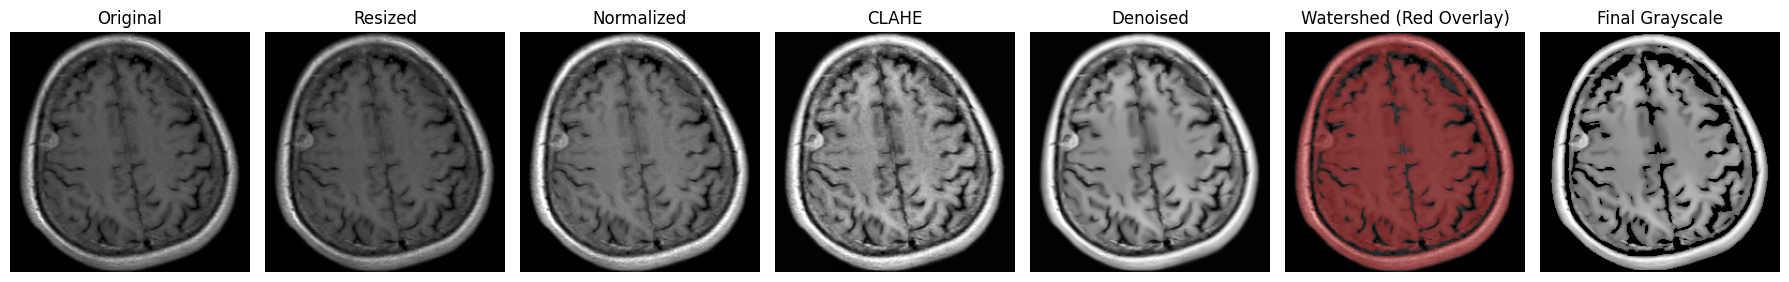


Class: 512Pituitary, Image: pituitary (205).jpg


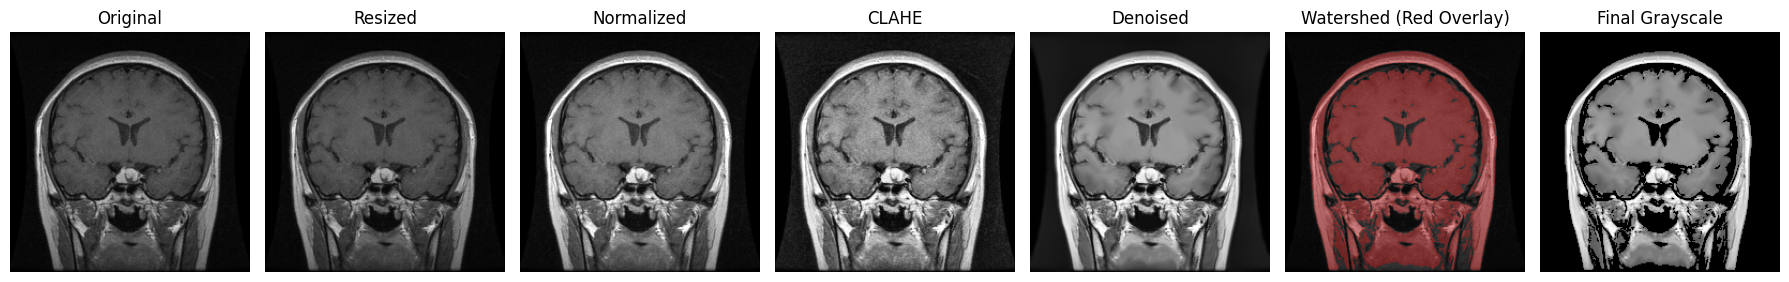


Class: 512Normal, Image: normal (279).jpg


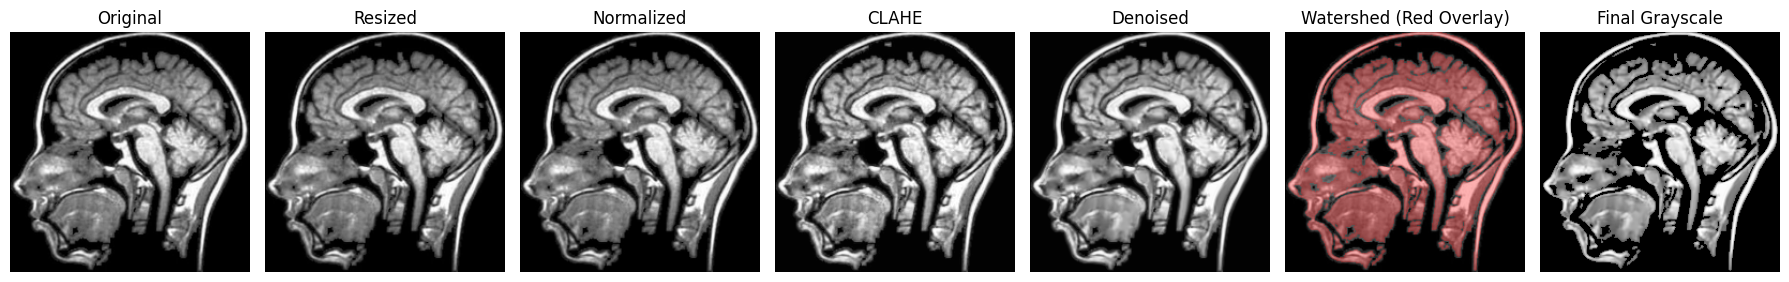


Starting batch preprocessing & saving all images...

All images preprocessed and saved in /kaggle/working/preprocessed/


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

# Paths and params
base_path = "/kaggle/input/pmrambrain/Raw"
output_base = "/kaggle/working/preprocessed"
class_dirs = ["512Glioma", "512Meningioma", "512Pituitary", "512Normal"]
img_size = (224, 224)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_image(path, img):
    cv2.imwrite(path, img)

def show_images(images, titles):
    plt.figure(figsize=(18, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def preprocess_image(img):
    results = {}

    # Step 1: Resize
    img_resized = cv2.resize(img, img_size)
    results['resized'] = img_resized

    # Step 2: Z-score normalization (grayscale)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_norm = (img_gray - np.mean(img_gray)) / (np.std(img_gray) + 1e-8)
    img_norm = np.clip(img_norm, -3, 3)
    img_norm = ((img_norm - img_norm.min()) / (img_norm.max() - img_norm.min()) * 255).astype(np.uint8)
    results['normalized'] = img_norm

    # Step 3: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_norm)
    results['clahe'] = img_clahe

    # Step 4: Denoising
    img_denoised = cv2.fastNlMeansDenoising(img_clahe, h=10, templateWindowSize=7, searchWindowSize=21)
    results['denoised'] = img_denoised

    # Step 5: Watershed mask
    ret, thresh = cv2.threshold(img_denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    distance = ndi.distance_transform_edt(thresh)

    coordinates = peak_local_max(distance, labels=thresh, footprint=np.ones((3, 3)))
    markers = np.zeros_like(distance, dtype=int)
    for i, coord in enumerate(coordinates, 1):
        markers[coord[0], coord[1]] = i

    labels = watershed(-distance, markers, mask=thresh)

    # Watershed mask (boolean)
    watershed_mask = (labels > 0)

    # Colored overlay in red on original resized image
    img_color = img_resized.copy()
    overlay = img_color.copy()
    overlay[watershed_mask] = [0, 0, 255]  # Red in BGR
    img_watershed = cv2.addWeighted(img_color, 0.7, overlay, 0.3, 0)
    results['watershed_color'] = img_watershed

    # Final grayscale preprocessed image = denoised image masked by watershed mask
    img_final_gray = cv2.bitwise_and(img_denoised, img_denoised, mask=watershed_mask.astype(np.uint8)*255)
    results['final_grayscale'] = img_final_gray

    return results

# Visualize and save images for one example per class
for class_name in class_dirs:
    class_path = os.path.join(base_path, class_name)
    save_class_base = os.path.join(output_base, class_name)
    sample_image_name = next((f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))), None)
    
    if sample_image_name:
        img_path = os.path.join(class_path, sample_image_name)
        img = cv2.imread(img_path)  # Read as color BGR
        print(f"\nClass: {class_name}, Image: {sample_image_name}")

        processed_imgs = preprocess_image(img)

        # Show preprocessing steps including watershed color overlay
        show_images(
            [img, processed_imgs['resized'], processed_imgs['normalized'], processed_imgs['clahe'], 
             processed_imgs['denoised'], processed_imgs['watershed_color'], processed_imgs['final_grayscale']],
            ['Original', 'Resized', 'Normalized', 'CLAHE', 'Denoised', 'Watershed (Red Overlay)', 'Final Grayscale']
        )

        # Save all preprocessed images for this class (one sample)
        for step_name, proc_img in processed_imgs.items():
            save_folder = os.path.join(save_class_base, step_name)
            ensure_dir(save_folder)
            save_path = os.path.join(save_folder, os.path.splitext(sample_image_name)[0] + '.png')
            save_image(save_path, proc_img)

# Batch preprocess and save all images (comment out to speed up)
print("\nStarting batch preprocessing & saving all images...")

for class_name in class_dirs:
    class_path = os.path.join(base_path, class_name)
    save_class_base = os.path.join(output_base, class_name)

    for filename in os.listdir(class_path):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)  # Read as color BGR

        processed_imgs = preprocess_image(img)
        for step_name, proc_img in processed_imgs.items():
            save_folder = os.path.join(save_class_base, step_name)
            ensure_dir(save_folder)
            save_path = os.path.join(save_folder, os.path.splitext(filename)[0] + '.png')
            save_image(save_path, proc_img)

print("\nAll images preprocessed and saved in /kaggle/working/preprocessed/")


In [10]:
import os
import cv2
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Setup paths and classes ===
class_dirs = ["512Glioma", "512Meningioma", "512Pituitary", "512Normal"]
preprocessed_path = "/kaggle/working/preprocessed"
augmented_base = "/kaggle/working/augmented"
split_base = "/kaggle/working/split_augmented"
img_size = (224, 224)
batch_size = 32

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# === Image Augmentation Function ===
def augment_image(img):
    augmented = []

    # Horizontal flip
    augmented.append(cv2.flip(img, 1))

    # Small rotation
    center = tuple(int(x) for x in np.array(img.shape[1::-1]) // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle=10, scale=1.0)
    rotated = cv2.warpAffine(img, rot_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    augmented.append(rotated)

    # Brightness and contrast
    bright_contrast = cv2.convertScaleAbs(img, alpha=1.2, beta=15)
    augmented.append(bright_contrast)

    return augmented

# === Step 1: Augment and save images ===
print("🔄 Augmenting images...")

for class_name in class_dirs:
    input_folder = os.path.join(preprocessed_path, class_name, "final_grayscale")
    output_class_folder = os.path.join(augmented_base, class_name)
    ensure_dir(output_class_folder)

    for fname in os.listdir(input_folder):
        if fname.lower().endswith('.png'):
            img_path = os.path.join(input_folder, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Save original
            cv2.imwrite(os.path.join(output_class_folder, fname), img)

            # Save augmentations
            augmented_imgs = augment_image(img)
            for i, aug_img in enumerate(augmented_imgs):
                aug_name = os.path.splitext(fname)[0] + f"_aug{i}.png"
                cv2.imwrite(os.path.join(output_class_folder, aug_name), aug_img)

print("✅ Augmentation complete. Images saved in /kaggle/working/augmented/")

# === Step 2: Split into train, val, test ===
def split_and_copy(class_name):
    img_folder = os.path.join(augmented_base, class_name)
    all_files = [f for f in os.listdir(img_folder) if f.endswith('.png')]
    random.shuffle(all_files)

    train_files, valtest_files = train_test_split(all_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(valtest_files, test_size=0.5, random_state=42)

    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(split_base, split, class_name)
        ensure_dir(split_class_dir)
        for f in split_files:
            src = os.path.join(img_folder, f)
            dst = os.path.join(split_class_dir, f)
            shutil.copy(src, dst)

print("\n📂 Splitting into train/val/test...")
for cls in class_dirs:
    split_and_copy(cls)

print("✅ Splitting complete. Images saved in /kaggle/working/split_augmented/")

# === Step 3: Print summary of splits ===
print("\n📊 Split Summary:\n")
for split in ["train", "val", "test"]:
    print(f"📁 {split.upper()} SET:")
    total = 0
    for class_name in class_dirs:
        class_path = os.path.join(split_base, split, class_name)
        count = len([f for f in os.listdir(class_path) if f.endswith('.png')])
        total += count
        print(f"  - {class_name:<15}: {count} images")
    print(f"  ➤ Total in {split}: {total} images\n")

# === Step 4: Load with ImageDataGenerator and encode labels ===
print("🧪 Preparing ImageDataGenerators with encoded labels...")

datagen = ImageDataGenerator(rescale=1./255)

# Force label order to be consistent
class_names = ["512Glioma", "512Meningioma", "512Pituitary", "512Normal"]

train_generator = datagen.flow_from_directory(
    directory=os.path.join(split_base, "train"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    classes=class_names
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(split_base, "val"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    classes=class_names
)

test_generator = datagen.flow_from_directory(
    directory=os.path.join(split_base, "test"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    classes=class_names
)

# === Step 5: Show class indices mapping ===
print("\n🧾 Class Indices Mapping:")
print(train_generator.class_indices)


🔄 Augmenting images...
✅ Augmentation complete. Images saved in /kaggle/working/augmented/

📂 Splitting into train/val/test...
✅ Splitting complete. Images saved in /kaggle/working/split_augmented/

📊 Split Summary:

📁 TRAIN SET:
  - 512Glioma      : 1424 images
  - 512Meningioma  : 1383 images
  - 512Pituitary   : 1433 images
  - 512Normal      : 1532 images
  ➤ Total in train: 5772 images

📁 VAL SET:
  - 512Glioma      : 281 images
  - 512Meningioma  : 274 images
  - 512Pituitary   : 287 images
  - 512Normal      : 307 images
  ➤ Total in val: 1149 images

📁 TEST SET:
  - 512Glioma      : 281 images
  - 512Meningioma  : 274 images
  - 512Pituitary   : 282 images
  - 512Normal      : 305 images
  ➤ Total in test: 1142 images

🧪 Preparing ImageDataGenerators with encoded labels...
Found 5772 images belonging to 4 classes.
Found 1149 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.

🧾 Class Indices Mapping:
{'512Glioma': 0, '512Meningioma': 1, '512Pituitary': 2, 

**NasNetMobile**

Found 5772 images belonging to 4 classes.
Found 5772 images belonging to 4 classes.
Found 1149 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 - 85s - 472ms/step - accuracy: 0.7337 - loss: 0.6904 - val_accuracy: 0.8294 - val_loss: 0.4409
Epoch 2/50
181/181 - 11s - 61ms/step - accuracy: 0.8470 - loss: 0.4206 - val_accuracy: 0.9017 - val_loss: 0.2863
Epoch 3/50
181/181 - 11s - 62ms/step - accuracy: 0.8744 - loss: 0.3486 - val_accuracy: 0.9339 - val_loss: 0.1788
Epoch 4/50
181/181 - 10s - 58ms/step - accuracy: 0.8881 - loss: 0.3206 - val_accuracy: 0.8842 - val_loss: 0.2800
Epoch 5/50
181/181 - 11s - 63ms/step - accuracy: 0.9040 - loss: 0.2619 - val_accuracy: 0.9252 - val_loss: 0.2108
Epoch 6/50
181/181 - 11s - 58ms/step - accuracy: 0.9222 - loss: 0.2192 - val_accuracy: 0.9112 - val_loss: 0.2463
Epoch 7/50
181/181 - 11s - 61ms/step - accuracy: 0.9182 - loss: 0.2196 - val_accuracy: 0.9504 - val_loss: 0.1371
Epoch 8/50
181/181 - 11s - 60ms/step - accuracy: 0.9272 - loss: 0.1989 - val_accuracy: 0.9547 - val_loss: 0.1196
Epoch 9/50
181/181 - 11s - 59ms/step - accuracy: 0.9288 - loss: 0.2021 - val_accuracy: 0.9600 - val_loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step
               precision    recall  f1-score   support

    512Glioma     0.9821    0.9786    0.9804       281
512Meningioma     0.9573    0.9818    0.9694       274
    512Normal     0.9967    1.0000    0.9984       305
 512Pituitary     0.9927    0.9681    0.9803       282

     accuracy                         0.9825      1142
    macro avg     0.9822    0.9821    0.9821      1142
 weighted avg     0.9827    0.9825    0.9825      1142

Cohen's Kappa: 0.9766


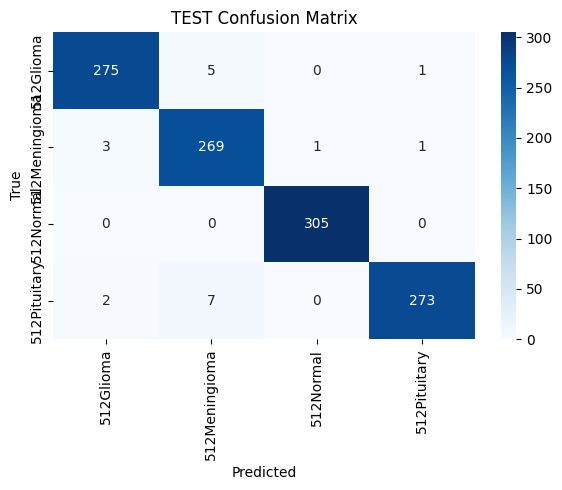

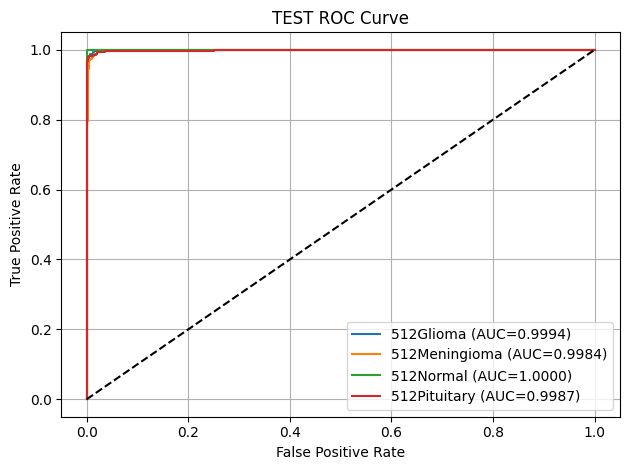

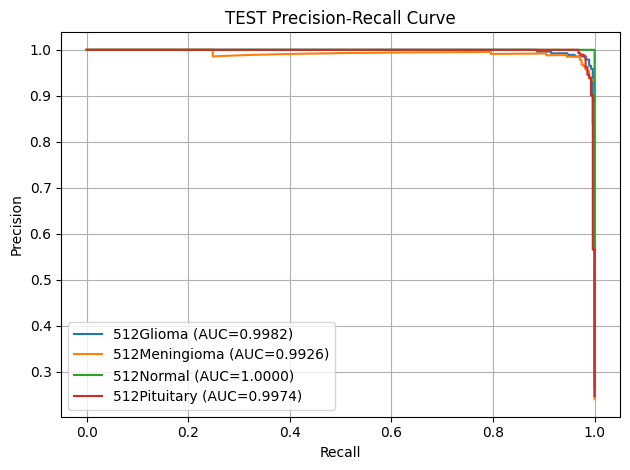

🕒 TEST Inference Time: 8.4928 seconds

📊 NASNetMobile Timing Summary:
🕒 Total Training Time   : 280.8248 seconds
🕒 Inference Time (Train): 38.4450 seconds
🕒 Inference Time (Val)  : 7.6907 seconds
🕒 Inference Time (Test) : 8.4928 seconds


In [12]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, cohen_kappa_score
)
from sklearn.preprocessing import label_binarize
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Data Loading ===
img_size = (224, 224)
batch_size = 32
data_path = '/kaggle/working/split_augmented'

datagen = ImageDataGenerator(rescale=1./255)

train_data_train = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

train_data_eval = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

val_data = datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

num_classes = train_data_train.num_classes
class_names = list(train_data_train.class_indices.keys())

# === NASNetMobile + MHSA Model ===
def build_nasnetmobile_mhsa(num_heads=4, key_dim=32):
    input_layer = Input(shape=(224, 224, 3))
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

# === Compile and Train ===
model_nasnet = build_nasnetmobile_mhsa()
model_nasnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

start_train = time.time()
history = model_nasnet.fit(
    train_data_train,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)
train_time = time.time() - start_train

# === Evaluation Function ===
def evaluate_model_with_mcnemar(model, data, split="TEST", show_plots=True):
    print(f"\n🧪 {split} Evaluation:")
    start_inf = time.time()
    preds = model.predict(data)
    inf_time = time.time() - start_inf

    y_pred = np.argmax(preds, axis=1)
    y_true = data.classes

    print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4
    ))

    print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

   

    if show_plots:
        # === Confusion Matrix ===
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{split} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # === ROC and PR Curves ===
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        fpr, tpr, roc_auc = {}, {}, {}
        precision, recall, pr_auc = {}, {}, {}

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            pr_auc[i] = auc(recall[i], precision[i])

        # ROC
        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={roc_auc[i]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{split} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        # PR
        plt.figure()
        for i in range(num_classes):
            plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC={pr_auc[i]:.4f})')
        plt.title(f'{split} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    print(f"🕒 {split} Inference Time: {inf_time:.4f} seconds")
    return inf_time

# === Evaluate on All Splits ===
inf_train = evaluate_model_with_mcnemar(model_nasnet, train_data_eval, split="TRAIN", show_plots=False)
inf_val = evaluate_model_with_mcnemar(model_nasnet, val_data, split="VALIDATION", show_plots=False)
inf_test = evaluate_model_with_mcnemar(model_nasnet, test_data, split="TEST", show_plots=True)

# === Timing Summary ===
print("\n📊 NASNetMobile Timing Summary:")
print(f"🕒 Total Training Time   : {train_time:.4f} seconds")
print(f"🕒 Inference Time (Train): {inf_train:.4f} seconds")
print(f"🕒 Inference Time (Val)  : {inf_val:.4f} seconds")
print(f"🕒 Inference Time (Test) : {inf_test:.4f} seconds")


**densenet201**

Found 5772 images belonging to 4 classes.
Found 5772 images belonging to 4 classes.
Found 1149 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 - 116s - 639ms/step - accuracy: 0.7465 - loss: 0.6667 - val_accuracy: 0.9112 - val_loss: 0.2638
Epoch 2/50
181/181 - 17s - 92ms/step - accuracy: 0.8928 - loss: 0.3034 - val_accuracy: 0.9460 - val_loss: 0.1441
Epoch 3/50
181/181 - 16s - 89ms/step - accuracy: 0.9260 - loss: 0.2094 - val_accuracy: 0.9217 - val_loss: 0.2212
Epoch 4/50
181/181 - 16s - 88ms/step - accuracy: 0.9241 - loss: 0.2288 - val_accuracy: 0.9452 - val_loss: 0.1745
Epoch 5/50
181/181 - 16s - 89ms/step - accuracy: 0.9345 - loss: 0.2044 - val_accuracy: 0.9547 - val_loss: 0.1255
Epoch 6/50
181/181 - 16s - 89ms/step - accuracy: 0.9513 - loss: 0.1498 - val_accuracy: 0.9565 - val_loss: 0.1072
Epoch 7/50
181/181 - 16s - 87ms/step - accuracy: 0.9482 - loss: 0.1597 - val_accuracy: 0.9434 - val_loss: 0.1593
Epoch 8/50
181/181 - 16s - 89ms/step - accuracy: 0.9576 - loss: 0.1361 - val_accuracy: 0.9800 - val_loss: 0.0740
Epoch 9/50
181/181 - 16s - 87ms/step - accuracy: 0.9723 - loss: 0.0858 - val_accuracy: 0.9582 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step
               precision    recall  f1-score   support

    512Glioma     1.0000    0.9715    0.9856       281
512Meningioma     0.9783    0.9891    0.9837       274
    512Normal     0.9903    1.0000    0.9951       305
 512Pituitary     0.9894    0.9965    0.9929       282

     accuracy                         0.9895      1142
    macro avg     0.9895    0.9893    0.9893      1142
 weighted avg     0.9896    0.9895    0.9895      1142

Cohen's Kappa: 0.9860


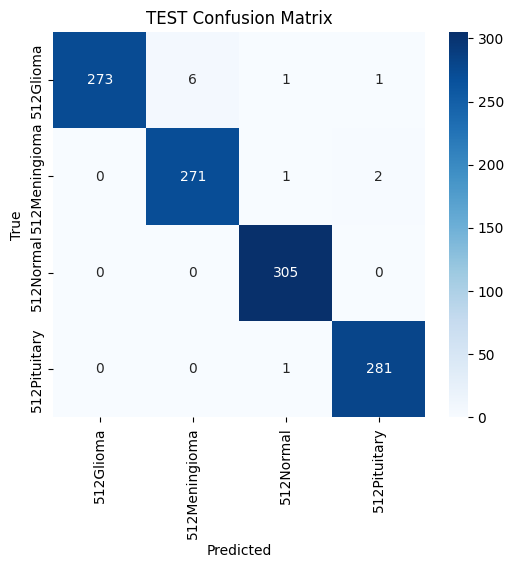

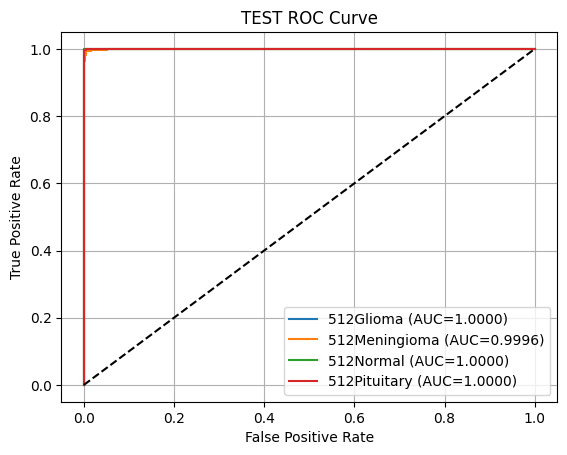

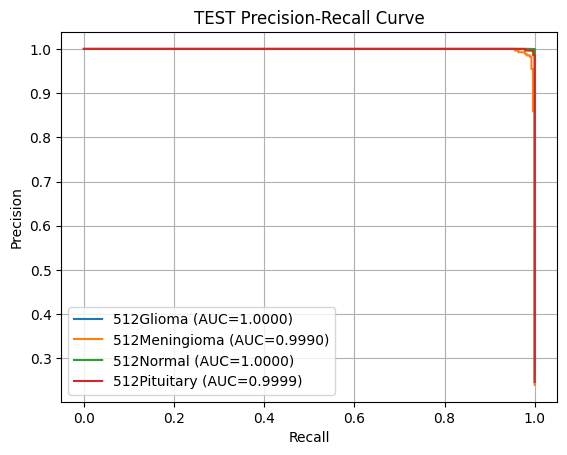

🕒 TEST Inference Time: 15.0781 seconds

📊 Timing Summary:
🕒 Total Training Time   : 484.8550 seconds
🕒 Inference Time (Train): 55.3090 seconds
🕒 Inference Time (Val)  : 13.0465 seconds
🕒 Inference Time (Test) : 15.0781 seconds


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Data Loading ===
img_size = (224, 224)
batch_size = 32
data_path = '/kaggle/working/split_augmented'

datagen = ImageDataGenerator(rescale=1./255)

train_data_train = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

train_data_eval = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

val_data = datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

num_classes = train_data_train.num_classes
class_names = list(train_data_train.class_indices.keys())

# === Model Definition ===
def build_densenet201_mhsa(num_heads=4, key_dim=32):
    input_layer = Input(shape=(224, 224, 3))
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

# === Compile & Train ===
model = build_densenet201_mhsa()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

start_train = time.time()
history = model.fit(
    train_data_train,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)
train_time = time.time() - start_train

# === Evaluation Function ===
def evaluate_model(model, data, split="TEST", show_plots=True):
    print(f"\n🧪 {split} Evaluation:")
    start_inf = time.time()
    preds = model.predict(data)
    inf_time = time.time() - start_inf

    y_pred = np.argmax(preds, axis=1)
    y_true = data.classes

    print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4
    ))

    print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

    if show_plots:
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{split} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Binarize labels
        y_true_bin = label_binarize(y_true, classes=range(num_classes))

        # ROC and PR curves
        fpr, tpr, roc_auc = {}, {}, {}
        precision, recall, pr_auc = {}, {}, {}

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            pr_auc[i] = auc(recall[i], precision[i])

        # ROC Curve
        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={roc_auc[i]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{split} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.show()

        # PR Curve
        plt.figure()
        for i in range(num_classes):
            plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC={pr_auc[i]:.4f})')
        plt.title(f'{split} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid()
        plt.show()

    print(f"🕒 {split} Inference Time: {inf_time:.4f} seconds")
    return inf_time

# === Run Evaluation ===
inf_train = evaluate_model(model, train_data_eval, split="TRAIN", show_plots=False)
inf_val = evaluate_model(model, val_data, split="VALIDATION", show_plots=False)
inf_test = evaluate_model(model, test_data, split="TEST", show_plots=True)

# === Print Summary ===
print("\n📊 Timing Summary:")
print(f"🕒 Total Training Time   : {train_time:.4f} seconds")
print(f"🕒 Inference Time (Train): {inf_train:.4f} seconds")
print(f"🕒 Inference Time (Val)  : {inf_val:.4f} seconds")
print(f"🕒 Inference Time (Test) : {inf_test:.4f} seconds")


** VGG19**

Found 5772 images belonging to 4 classes.
Found 5772 images belonging to 4 classes.
Found 1149 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 - 32s - 175ms/step - accuracy: 0.6457 - loss: 0.8403 - val_accuracy: 0.8346 - val_loss: 0.4774
Epoch 2/50
181/181 - 19s - 105ms/step - accuracy: 0.8243 - loss: 0.4857 - val_accuracy: 0.8668 - val_loss: 0.3719
Epoch 3/50
181/181 - 19s - 104ms/step - accuracy: 0.8586 - loss: 0.3826 - val_accuracy: 0.8930 - val_loss: 0.2909
Epoch 4/50
181/181 - 19s - 104ms/step - accuracy: 0.8756 - loss: 0.3522 - val_accuracy: 0.9025 - val_loss: 0.2725
Epoch 5/50
181/181 - 19s - 105ms/step - accuracy: 0.8872 - loss: 0.3169 - val_accuracy: 0.9121 - val_loss: 0.2411
Epoch 6/50
181/181 - 19s - 105ms/step - accuracy: 0.9011 - loss: 0.2719 - val_accuracy: 0.9252 - val_loss: 0.1920
Epoch 7/50
181/181 - 19s - 105ms/step - accuracy: 0.9127 - loss: 0.2424 - val_accuracy: 0.9408 - val_loss: 0.1565
Epoch 8/50
181/181 - 19s - 105ms/step - accuracy: 0.9132 - loss: 0.2396 - val_accuracy: 0.9373 - val_loss: 0.1712
Epoch 9/50
181/181 - 19s - 106ms/step - accuracy: 0.9132 - loss: 0.2465 - val_accuracy: 0.9460 - va

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step
               precision    recall  f1-score   support

    512Glioma     0.9964    0.9822    0.9892       281
512Meningioma     0.9925    0.9672    0.9797       274
    512Normal     0.9713    1.0000    0.9855       305
 512Pituitary     0.9930    1.0000    0.9965       282

     accuracy                         0.9877      1142
    macro avg     0.9883    0.9873    0.9877      1142
 weighted avg     0.9879    0.9877    0.9877      1142

Cohen's Kappa: 0.9836


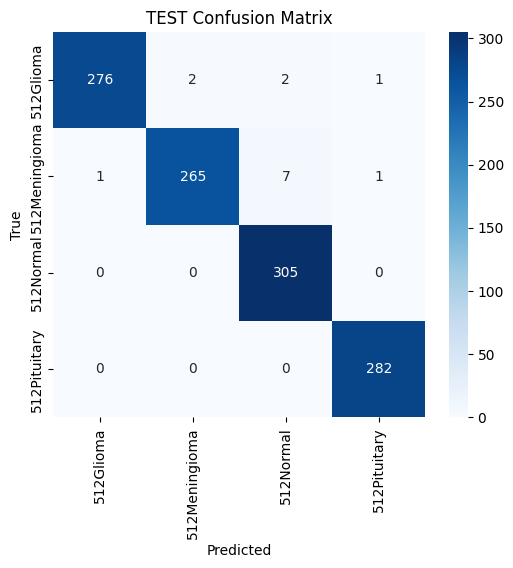

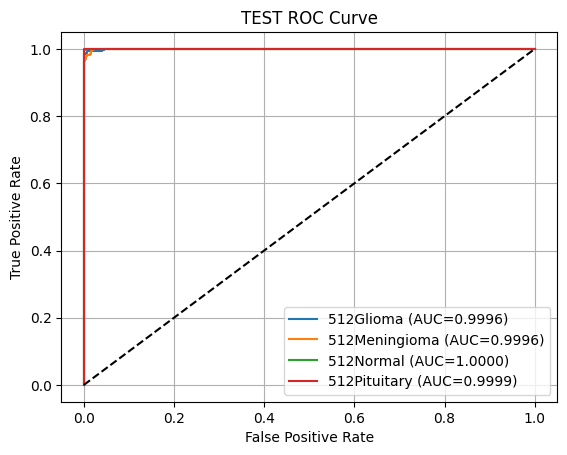

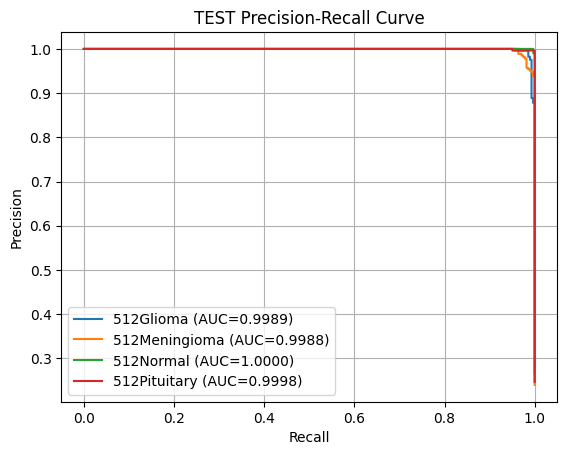

🕒 TEST Inference Time: 8.2269 seconds

📊 Timing Summary:
🕒 Total Training Time   : 658.3724 seconds
🕒 Inference Time (Train): 17.7401 seconds
🕒 Inference Time (Val)  : 3.7260 seconds
🕒 Inference Time (Test) : 8.2269 seconds


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Data Loading ===
img_size = (224, 224)
batch_size = 32
data_path = '/kaggle/working/split_augmented'

datagen = ImageDataGenerator(rescale=1./255)

train_data_train = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

train_data_eval = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

val_data = datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

num_classes = train_data_train.num_classes
class_names = list(train_data_train.class_indices.keys())

# === Model Definition ===
def build_vgg19_mhsa(num_heads=4, key_dim=32):
    input_layer = Input(shape=(224, 224, 3))
    base_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

# === Compile & Train ===
model = build_vgg19_mhsa()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

start_train = time.time()
history = model.fit(
    train_data_train,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)
train_time = time.time() - start_train

# === Evaluation Function ===
def evaluate_model(model, data, split="TEST", show_plots=True):
    print(f"\n🧪 {split} Evaluation:")
    start_inf = time.time()
    preds = model.predict(data)
    inf_time = time.time() - start_inf

    y_pred = np.argmax(preds, axis=1)
    y_true = data.classes

    print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4
    ))

    print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

    if show_plots:
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{split} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Binarize labels
        y_true_bin = label_binarize(y_true, classes=range(num_classes))

        # ROC and PR curves
        fpr, tpr, roc_auc = {}, {}, {}
        precision, recall, pr_auc = {}, {}, {}

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            pr_auc[i] = auc(recall[i], precision[i])

        # ROC Curve
        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC={roc_auc[i]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{split} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.show()

        # PR Curve
        plt.figure()
        for i in range(num_classes):
            plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AUC={pr_auc[i]:.4f})')
        plt.title(f'{split} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid()
        plt.show()

    print(f"🕒 {split} Inference Time: {inf_time:.4f} seconds")
    return inf_time

# === Run Evaluation ===
inf_train = evaluate_model(model, train_data_eval, split="TRAIN", show_plots=False)
inf_val = evaluate_model(model, val_data, split="VALIDATION", show_plots=False)
inf_test = evaluate_model(model, test_data, split="TEST", show_plots=True)

# === Print Summary ===
print("\n📊 Timing Summary:")
print(f"🕒 Total Training Time   : {train_time:.4f} seconds")
print(f"🕒 Inference Time (Train): {inf_train:.4f} seconds")
print(f"🕒 Inference Time (Val)  : {inf_val:.4f} seconds")
print(f"🕒 Inference Time (Test) : {inf_test:.4f} seconds")


***MOBILENETV2***

Found 5772 images belonging to 4 classes.
Found 5772 images belonging to 4 classes.
Found 1149 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.


/tmp/ipykernel_35/1344005987.py:64: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,278,916 (12.51 MB)

 Trainable params: 1,020,932 (3.89 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 - 33s - 184ms/step - accuracy: 0.7819 - loss: 0.5704 - val_accuracy: 0.8860 - val_loss: 0.3202
Epoch 2/50
181/181 - 9s - 50ms/step - accuracy: 0.9052 - loss: 0.2698 - val_accuracy: 0.9156 - val_loss: 0.2217
Epoch 3/50
181/181 - 9s - 50ms/step - accuracy: 0.9233 - loss: 0.2240 - val_accuracy: 0.9469 - val_loss: 0.1707
Epoch 4/50
181/181 - 9s - 50ms/step - accuracy: 0.9380 - loss: 0.1864 - val_accuracy: 0.9617 - val_loss: 0.1181
Epoch 5/50
181/181 - 9s - 50ms/step - accuracy: 0.9551 - loss: 0.1252 - val_accuracy: 0.9800 - val_loss: 0.0615
Epoch 6/50
181/181 - 9s - 52ms/step - accuracy: 0.9619 - loss: 0.1152 - val_accuracy: 0.9843 - val_loss: 0.0412
Epoch 7/50
181/181 - 9s - 51ms/step - accuracy: 0.9761 - loss: 0.0795 - val_accuracy: 0.9809 - val_loss: 0.0528
Epoch 8/50
181/181 - 9s - 51ms/step - accuracy: 0.9716 - loss: 0.0889 - val_accuracy: 0.9547 - val_loss: 0.1188
Epoch 9/50
181/181 - 9s - 50ms/step - accuracy: 0.9681 - loss: 0.0986 - val_accuracy: 0.9617 - val_loss: 0.1134
E

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
               precision    recall  f1-score   support

    512Glioma     0.9825    1.0000    0.9912       281
512Meningioma     1.0000    0.9927    0.9963       274
    512Normal     1.0000    1.0000    1.0000       305
 512Pituitary     0.9928    0.9823    0.9875       282

     accuracy                         0.9939      1142
    macro avg     0.9938    0.9937    0.9938      1142
 weighted avg     0.9939    0.9939    0.9939      1142

Cohen's Kappa: 0.9918


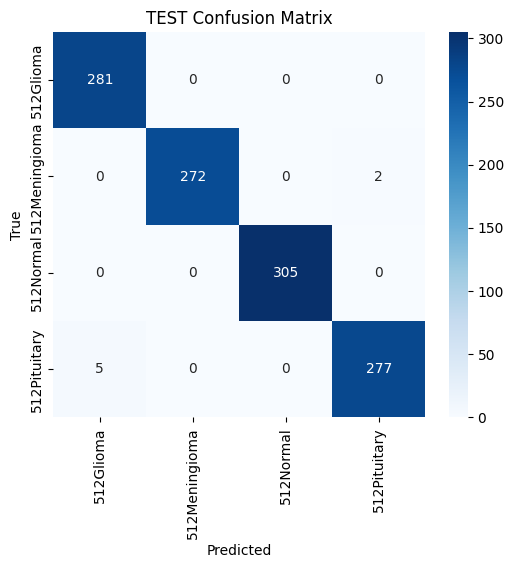

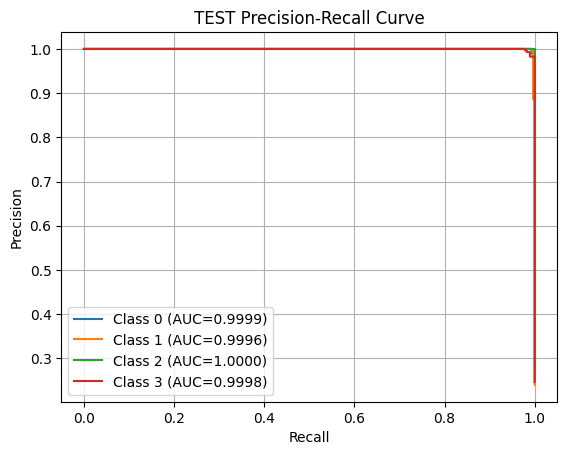

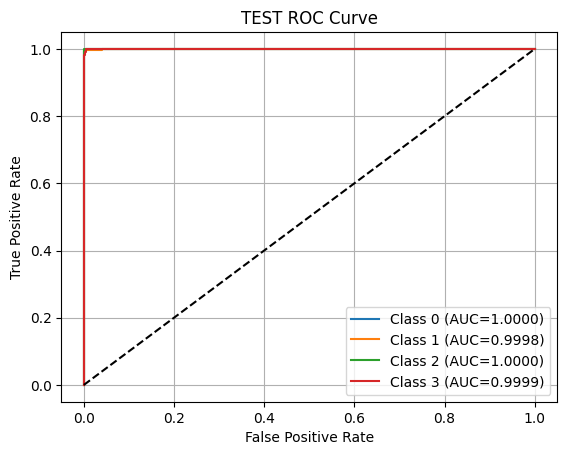

🕒 Inference Time: 3.3794 seconds

🕒 Total Training Time: 293.9331 seconds
🕒 Inference Time (Train): 14.8198s, (Val): 3.2382s, (Test): 3.3794s


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === DATA LOADING ===
img_size = (224, 224)
batch_size = 32
data_path = '/kaggle/working/split_augmented'

datagen = ImageDataGenerator(rescale=1./255)

train_data_train = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

train_data_eval = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

val_data = datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

num_classes = train_data_train.num_classes

# === MODEL ===
def build_mobilenetv2_mhsa(num_heads=4, key_dim=32):
    input_layer = Input(shape=(224, 224, 3))
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = build_mobilenetv2_mhsa()
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# === TRAINING ===
start_train = time.time()
history = model.fit(
    train_data_train,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)
train_time = time.time() - start_train

# === EVALUATION ===
def evaluate_model(model, data, split="TEST", show_plots=True):
    print(f"\n🧪 {split} Evaluation:")
    start_inf = time.time()
    preds = model.predict(data)
    inf_time = time.time() - start_inf

    y_pred = np.argmax(preds, axis=1)
    y_true = data.classes

    print(classification_report(
        y_true, y_pred,
        target_names=list(data.class_indices.keys()),
        digits=4
    ))

    print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

    if show_plots:
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=data.class_indices,
                    yticklabels=data.class_indices)
        plt.title(f'{split} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        y_true_bin = label_binarize(y_true, classes=range(num_classes))

        # Precision-Recall Curve
        precision, recall, pr_auc = {}, {}, {}
        for i in range(num_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
            pr_auc[i] = auc(recall[i], precision[i])

        plt.figure()
        for i in range(num_classes):
            plt.plot(recall[i], precision[i], label=f'Class {i} (AUC={pr_auc[i]:.4f})')
        plt.title(f'{split} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid()
        plt.show()

        # ROC Curve
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC={roc_auc[i]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{split} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.show()

    print(f"🕒 Inference Time: {inf_time:.4f} seconds\n")
    return inf_time

# Evaluate
inf_train = evaluate_model(model, train_data_eval, split="TRAIN", show_plots=False)
inf_val = evaluate_model(model, val_data, split="VALIDATION", show_plots=False)
inf_test = evaluate_model(model, test_data, split="TEST", show_plots=True)

# Summary
print(f"🕒 Total Training Time: {train_time:.4f} seconds")
print(f"🕒 Inference Time (Train): {inf_train:.4f}s, (Val): {inf_val:.4f}s, (Test): {inf_test:.4f}s")


**FUSION MODEL START FROM HERE**

**2**

**3**

Found 5772 images belonging to 4 classes.
Found 5772 images belonging to 4 classes.
Found 1149 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.


/tmp/ipykernel_35/2515767263.py:81: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_5 (InputLayer)        │ (None, 224, 224, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ zero_padding2d_8 (ZeroPadding2D)  │ (None, 230, 230, 3)          │                 0 │ input_layer_5[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_conv (Conv2D)               │ (None, 112, 112, 64)         │             9,408 │ zero_padding2d_8[0][0]    
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_bn (BatchNormalization)     │ (None, 112, 112, 64)         │               256 │ conv1_conv[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1_relu (Activation)           │ (None, 112, 112, 64)         │                 0 │ conv1_bn[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ zero_padding2d_9 (ZeroPadding2D)  │ (None, 114, 114, 64)         │                 0 │ conv1_relu[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pool1 (MaxPooling2D)              │ (None, 56, 56, 64)           │                 0 │ zero_padding2d_9[0][0]    
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_0_bn                 │ (None, 56, 56, 64)           │               256 │ pool1[0][0]               
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_0_relu (Activation)  │ (None, 56, 56, 64)           │                 0 │ conv2_block1_0_bn[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_conv (Conv2D)      │ (None, 56, 56, 128)          │             8,192 │ conv2_block1_0_relu[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_bn                 │ (None, 56, 56, 128)          │               512 │ conv2_block1_1_conv[0][0] 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_1_relu (Activation)  │ (None, 56, 56, 128)          │                 0 │ conv2_block1_1_bn[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_2_conv (Conv2D)      │ (None, 56, 56, 32)           │            36,864 │ conv2_block1_1_relu[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block1_concat (Concatenate) │ (None, 56, 56, 96)           │                 0 │ pool1[0][0],              
│                                   │                              │                   │ conv2_block1_2_conv[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2_block2_0_bn                 │ (None, 56, 56, 96)

 Total params: 42,751,236 (163.08 MB)

 Trainable params: 22,171,268 (84.58 MB)

 Non-trainable params: 20,579,968 (78.51 MB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 - 155s - 857ms/step - accuracy: 0.4541 - loss: 1.2766 - val_accuracy: 0.7015 - val_loss: 0.7496
Epoch 2/50
181/181 - 26s - 143ms/step - accuracy: 0.7432 - loss: 0.6453 - val_accuracy: 0.8825 - val_loss: 0.3425
Epoch 3/50
181/181 - 25s - 140ms/step - accuracy: 0.8633 - loss: 0.4236 - val_accuracy: 0.8581 - val_loss: 0.3698
Epoch 4/50
181/181 - 26s - 144ms/step - accuracy: 0.9170 - loss: 0.2630 - val_accuracy: 0.9269 - val_loss: 0.2092
Epoch 5/50
181/181 - 26s - 143ms/step - accuracy: 0.9432 - loss: 0.1964 - val_accuracy: 0.9330 - val_loss: 0.2465
Epoch 6/50
181/181 - 26s - 144ms/step - accuracy: 0.9435 - loss: 0.1948 - val_accuracy: 0.9565 - val_loss: 0.1447
Epoch 7/50
181/181 - 26s - 143ms/step - accuracy: 0.9641 - loss: 0.1219 - val_accuracy: 0.9817 - val_loss: 0.0695
Epoch 8/50
181/181 - 26s - 142ms/step - accuracy: 0.9605 - loss: 0.1400 - val_accuracy: 0.9791 - val_loss: 0.0784
Epoch 9/50
181/181 - 26s - 141ms/step - accuracy: 0.9657 - loss: 0.1160 - val_accuracy: 0.9730 - v

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 714ms/step
               precision    recall  f1-score   support

    512Glioma     1.0000    0.9929    0.9964       281
512Meningioma     0.9927    0.9964    0.9945       274
    512Normal     1.0000    1.0000    1.0000       305
 512Pituitary     0.9965    1.0000    0.9982       282

     accuracy                         0.9974      1142
    macro avg     0.9973    0.9973    0.9973      1142
 weighted avg     0.9974    0.9974    0.9974      1142

Cohen's Kappa: 0.9965
Wilcoxon signed-rank test: statistic=1714.5000, p-value=0.0000


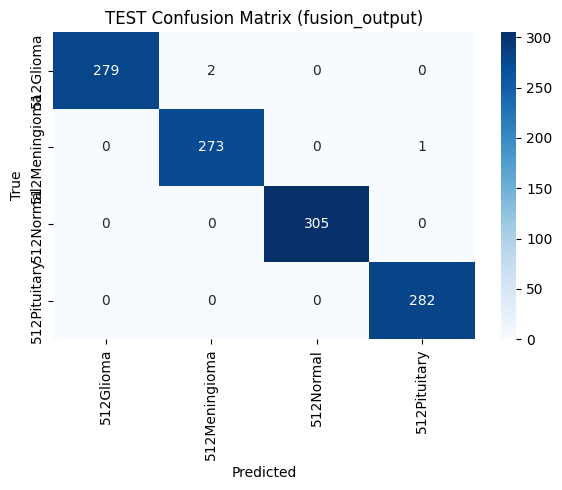

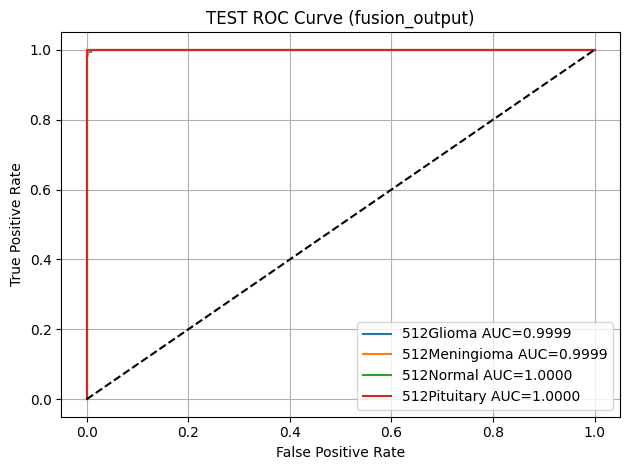

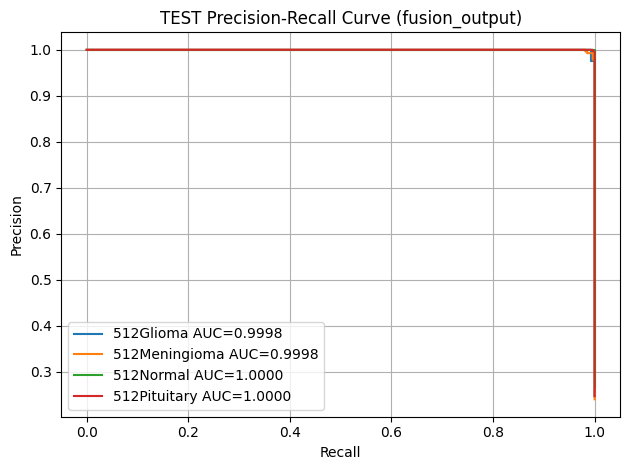

🕒 Inference Time: 25.2585 seconds
⚡ Inference Time per sample: 0.022118 seconds/sample



In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.applications import DenseNet201, MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Reshape, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from scipy.stats import wilcoxon

# Setup
img_size = (224, 224)
batch_size = 32
epochs = 50
data_path = '/kaggle/working/split_augmented'

datagen = ImageDataGenerator(rescale=1./255)

train_data_train = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=True
)

train_data_eval = datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False
)

val_data = datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False
)

num_classes = train_data_train.num_classes
class_names = list(train_data_train.class_indices.keys())

# MHSA block
def add_mhsa_block(x, heads=4):
    shape = x.shape
    x = Reshape((-1, shape[-1]))(x)
    x = MultiHeadAttention(num_heads=heads, key_dim=shape[-1] // heads)(x, x)
    x = LayerNormalization()(x)
    return GlobalAveragePooling2D()(Reshape((shape[1], shape[2], shape[-1]))(x))

# Fusion Model
def build_fusion_model():
    input_layer = Input(shape=(224, 224, 3))

    base1 = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base1.layers:
        layer.trainable = False
    x1 = add_mhsa_block(base1.output)

    base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base2.layers:
        layer.trainable = False
    x2 = add_mhsa_block(base2.output)

    fused = Concatenate()([x1, x2])
    fused = Dense(256, activation='relu')(fused)
    fused = Dropout(0.5)(fused)
    fused = Dense(128, activation='relu')(fused)
    output = Dense(num_classes, activation='softmax', name='fusion_output')(fused)

    return Model(inputs=input_layer, outputs=output)

# Compile & Train
model = build_fusion_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

start_train = time.time()
history = model.fit(
    train_data_train,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=2
)
train_time = time.time() - start_train
print(f"\n🕒 Total Training Time: {train_time:.2f} seconds")

# Evaluation Function
def evaluate_model(model, data, split="TEST", show_plots=True):
    print(f"\n🧪 {split} Evaluation (fusion_output):")
    start_inf = time.time()
    preds = model.predict(data)
    inf_time = time.time() - start_inf

    y_pred = np.argmax(preds, axis=1)
    y_true = data.classes

    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

    try:
        stat, p = wilcoxon((y_true == y_pred).astype(int) - 0.5)
        print(f"Wilcoxon signed-rank test: statistic={stat:.4f}, p-value={p:.4f}")
    except Exception as e:
        print("Wilcoxon test error:", e)

    if show_plots:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title(f'{split} Confusion Matrix (fusion_output)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        fpr, tpr, roc_auc = {}, {}, {}
        precision, recall, pr_auc = {}, {}, {}

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            pr_auc[i] = auc(recall[i], precision[i])

        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} AUC={roc_auc[i]:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{split} ROC Curve (fusion_output)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        plt.figure()
        for i in range(num_classes):
            plt.plot(recall[i], precision[i], label=f'{class_names[i]} AUC={pr_auc[i]:.4f}')
        plt.title(f'{split} Precision-Recall Curve (fusion_output)')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    print(f"🕒 Inference Time: {inf_time:.4f} seconds")
    print(f"⚡ Inference Time per sample: {inf_time / len(data.filenames):.6f} seconds/sample\n")

# Evaluate
evaluate_model(model, train_data_eval, split="TRAIN", show_plots=False)
evaluate_model(model, val_data, split="VALIDATION", show_plots=False)
evaluate_model(model, test_data, split="TEST", show_plots=True)


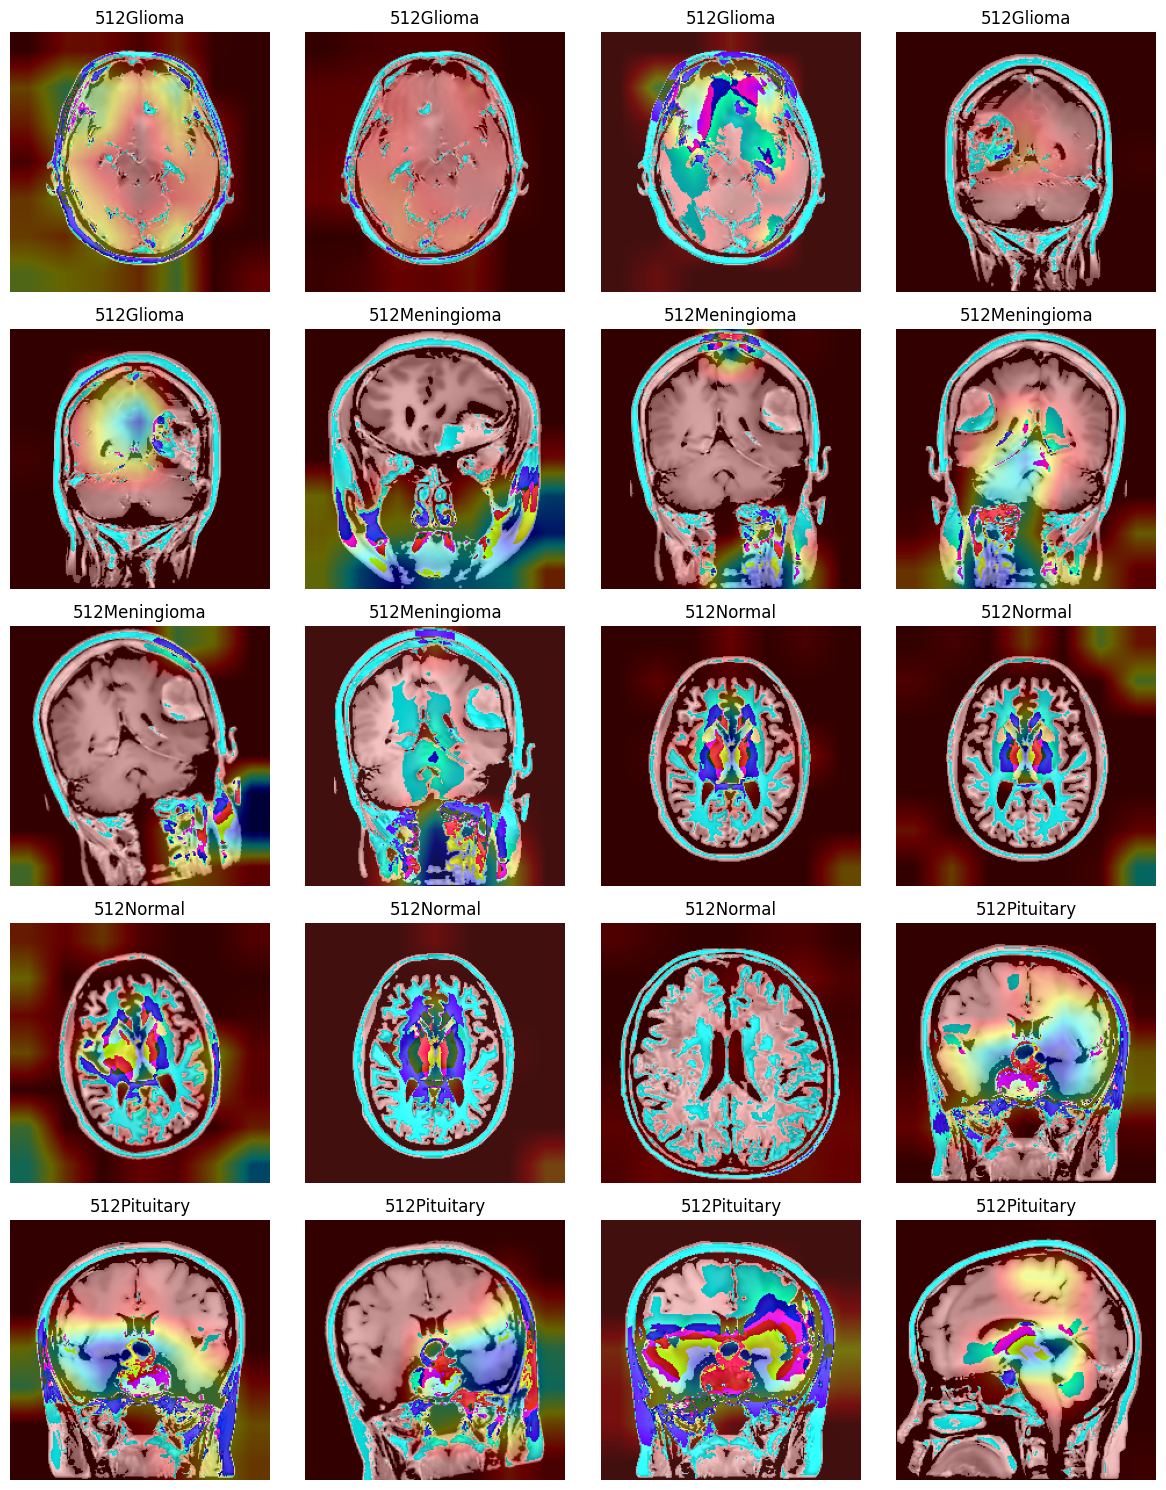

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and labels from generator (train_data_eval)
all_images = []
all_labels = []

for i in range(len(train_data_eval)):
    imgs, labels = train_data_eval[i]
    all_images.append(imgs)
    all_labels.append(labels)

all_images = np.vstack(all_images)
all_labels = np.vstack(all_labels)
all_classes = np.argmax(all_labels, axis=1)  # get class indices

# Map class index to class name
class_indices = train_data_eval.class_indices
index_to_class = {v:k for k,v in class_indices.items()}

# Pick 5 samples per class
num_samples_per_class = 5
selected_indices = []

for cls_idx in range(len(class_indices)):
    cls_samples = np.where(all_classes == cls_idx)[0]
    selected_indices.extend(cls_samples[:num_samples_per_class])

# Plot Grad-CAM only for selected images
plt.figure(figsize=(12, 3 * num_samples_per_class))

for i, idx in enumerate(selected_indices):
    img = all_images[idx]
    img_uint8 = (img * 255).astype(np.uint8)
    img_input = np.expand_dims(img, axis=0)

    cls_idx = all_classes[idx]
    cls_name = index_to_class[cls_idx]

    # Grad-CAM on MobileNetV2 last conv layer
    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name="Conv_1")
    cam_img = overlay_gradcam(img_uint8, heatmap)

    # Plot Grad-CAM
    plt.subplot(num_samples_per_class, len(class_indices), i + 1)
    plt.imshow(cam_img)
    plt.title(f"{cls_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


**2**

**proposed**